## Importing required libraries

In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, normalized_mutual_info_score

## 1. Merging datasets

In [17]:
#creating a new dataframe to store the merged csv files
data = pd.DataFrame()
FILEPATH = "/course/data/a2/games/"
filenames = ['NAmatch.csv', 'KRmatch.csv', 'EUmatch.csv']

all_datasets = []
for filename in filenames:
    all_datasets.append(pd.read_csv(FILEPATH + filename))

merged_data = pd.concat(all_datasets)
print(f'Current data points: {len(merged_data)}')

Current data points: 17228


## 2. Filtering relevant data

In [18]:
#remove data points with NaN 'champion' values
filtered_data = merged_data.dropna(subset=['champion'])

#to store champions typically played as toplaner or jungler role
toplane_jungle = []

for character in filtered_data['champion'].unique():
    #get number of times champion is played as 'Other' and number of times played as 'TopLane_Jungle'
    champion_data = filtered_data.query(f'champion == "{character}"')
    role_data = champion_data.groupby('role').size()
    
    #if champion is played as 'Other' zero times, they must be typically played as toplaner or jungler
    try: 
        other_size = role_data["Other"]
    except KeyError:
        toplane_jungle.append(character)
        continue

    #skip if champion has never been played as toplaner or jungler
    try: 
        toplane_jungle_size = role_data["TopLane_Jungle"]
    except KeyError:
        continue
    
    #if champion is played as a toplaner or jungler more than 50% of the time, they are typically
    #played as a toplaner or jungler. add to toplane_jungle
    proportion_toplane_jungle = toplane_jungle_size/(other_size+toplane_jungle_size)
    if proportion_toplane_jungle > 0.5:
        toplane_jungle.append(character)

#filter dataset to only include champions typically played as toplaner or jungler
filtered_data = filtered_data.query(f'champion in {toplane_jungle}')
#filter dataset to only include matches where champions are played as toplaner or jungler
filtered_data = filtered_data.query('role == "TopLane_Jungle"')

#drop all irrelevant values from dataset
filtered_data = filtered_data.drop(columns=['d_spell', 'f_spell', 'champion', 'side', 'role', 'minions_killed'])
filtered_data = filtered_data.reset_index(drop=True)

print(f'Data points after filtering: {len(filtered_data)}')

Data points after filtering: 6123


## 3. Train-test split

In [19]:
#split data into training and testing sets
train, test = train_test_split(filtered_data, shuffle=True, random_state=1)

## 4. Numerical Imputation

In [20]:
feature_means = {}
integer_features = train.columns.drop('kda')

#find mean value of each integer feature
for feature in integer_features:
    feature_means[feature] = int(train[feature].mean())

#find mean value of each non-integer feature ('kda')
feature_means['kda'] = train['kda'].mean()

#for integer features, round the mean into an integer
for feature in train[train.columns]:
    train[feature] = train[feature].replace(np.nan, feature_means[feature])

## 5. Ordinalization

In [21]:
#functions to ordinalize features, based on given lower and upper boundaries
def ordinalize_features(value, lower_bound, upper_bound):
    if value > upper_bound:
        return 2
    elif value > lower_bound:
        return 1
    else:
        return 0

def discretize_dmg_total(value, lower_bound, upper_bound):
    if value > upper_bound:
        return "high"
    elif value > lower_bound:
        return "mid" 
    else:
        return "low"

### Ordinalize training set

In [22]:
"""Assume that the frequency of occurences of "low", "mid", and "high" for each numeric feature
approximately mimics that of a normal distribution.
"low" (0): 0 <= value <= 16th percentile
"mid" (1): 16th percentile < value < 84th percentile
"high" (2): 84th percentile <= value < 100th percentile"""

#data instance that will give the 16th percentile in a dataset sorted by the feature
lower_bound_frequency = int(len(train)*0.16)
#data instance that will give the 84th percentile in a dataset sorted by the feature
upper_bound_frequency = int(len(train)*0.84)

#to store bins used to classify features
feature_bins = {}

#to store the ordinalized features
ordinalized_train = pd.DataFrame()

column = 'damage_total'
#sort the dataframe by the feature in ascending order
sorted_df = train.sort_values(column).reset_index(drop=True)
#value of the 16th percentile of the feature
lower = sorted_df.iloc[lower_bound_frequency][column]
#value of the 84th percentile of the feature
upper = sorted_df.iloc[upper_bound_frequency][column]

label_bins = [lower, upper]
feature_bins[column] = label_bins

# ordinalize the feature
ordinalized_train[column] = train[column].apply(discretize_dmg_total, args=(label_bins))

# ordinalize remaining features with same method
features = train.columns.drop('damage_total')
for column in features:
    sorted_df = train.sort_values(column).reset_index(drop=True)
    lower = sorted_df.iloc[lower_bound_frequency][column]
    upper = sorted_df.iloc[upper_bound_frequency][column]
    label_bins = [lower, upper]
    feature_bins[column] = label_bins
    ordinalized_train[column] = train[column].apply(ordinalize_features, args=(label_bins))

## 6. Feature selection

In [23]:
# threshold normalized mutual information level for accepting / rejecting features
THRESHOLD = 0.125

selected_features = []
for feature in features:
    nmi = normalized_mutual_info_score(ordinalized_train['damage_total'], ordinalized_train[feature])
    print(f'NMI value for feature "{feature}": {nmi:.4f}')
    if(nmi >= THRESHOLD): 
        selected_features.append(feature)

print('\nFeature set after filtering with MI:', selected_features)
filtered_data_columns = selected_features + ['damage_total']

# filter dataset such that only selected features will be used for further processing
filtered_data = ordinalized_train[filtered_data_columns]
x_train = filtered_data.drop(columns=["damage_total"])
y_train = filtered_data["damage_total"]

NMI value for feature "assists": 0.0690
NMI value for feature "damage_objectives": 0.0313
NMI value for feature "damage_building": 0.1732
NMI value for feature "damage_turrets": 0.0302
NMI value for feature "deaths": 0.0028
NMI value for feature "kda": 0.0606
NMI value for feature "kills": 0.1055
NMI value for feature "level": 0.2818
NMI value for feature "time_cc": 0.0165
NMI value for feature "damage_taken": 0.1347
NMI value for feature "turret_kills": 0.0453
NMI value for feature "vision_score": 0.1278
NMI value for feature "gold_earned": 0.3418

Feature set after filtering with MI: ['damage_building', 'level', 'damage_taken', 'vision_score', 'gold_earned']


### Ordinalize test set and only include selected features

In [24]:
x_test = pd.DataFrame()
for feature in selected_features:
    x_test[feature] = test[feature].apply(ordinalize_features, args=(feature_bins[feature]))

y_test = test['damage_total'].apply(discretize_dmg_total, args=(feature_bins['damage_total']))

## 7. Decision Tree

### Find best decision tree depth

In [25]:
min_samples_leaf = int(len(x_train)*0.01)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

depth_accuracies=[]
for i in range(3,8):
    dt_model = DecisionTreeClassifier(max_depth=i, min_samples_leaf=min_samples_leaf)
    scores = cross_val_score(estimator=dt_model, X=x_train, y=y_train, cv=kf)
    depth_accuracies.append((i, scores.mean()))

best_depth = max(depth_accuracies, key=lambda item:item[1])[0]
print("Best tree depth:", best_depth)

Best tree depth: 3


### Fit decision tree model to training set

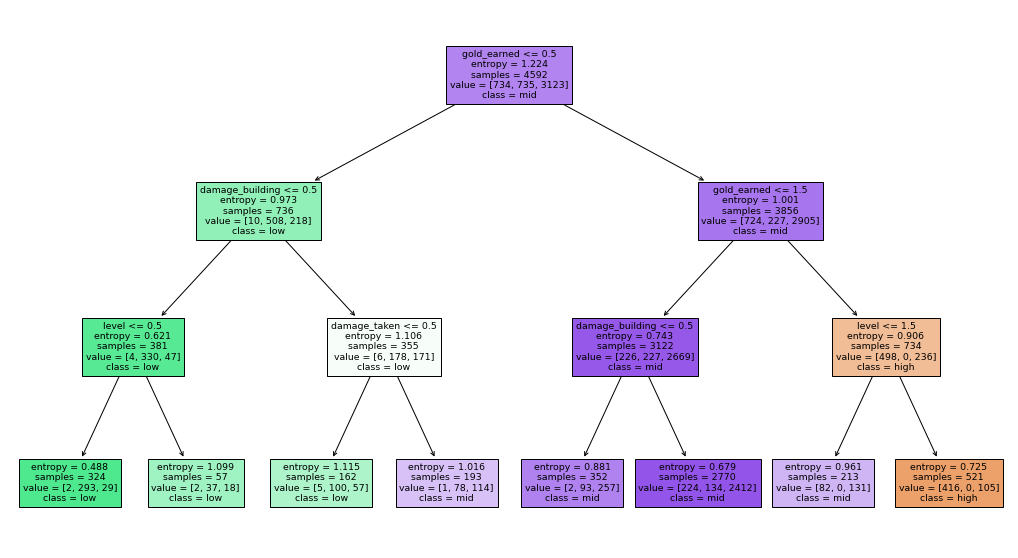

In [26]:
#generate final decision tree model to be tested on test set
decision_tree = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=min_samples_leaf, criterion='entropy')
decision_tree.fit(x_train, y_train)

fig, axes = plt.subplots(figsize=(18,10))
plot_tree(decision_tree, # the DT classifier
          feature_names=selected_features, # feature names
          class_names=decision_tree.classes_, # class labels
          filled=True, # fill in the rectangles
          ax = axes,
         )

plt.savefig("dt.pdf")
plt.show()

### Evaluate decision tree model with test set

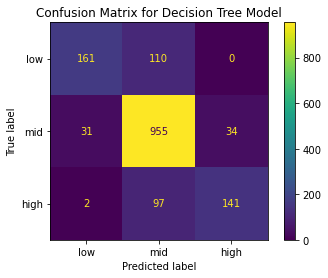

Accuracy: 0.8210320052253429
f1: 0.7491116373084267


In [27]:
dt_pred = decision_tree.predict(x_test)
dt_accuracy = decision_tree.score(x_test, y_test)

cm_dt = confusion_matrix(y_test, dt_pred, labels=["low", "mid", "high"])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["low", "mid", "high"])

cm_disp.plot()

plt.title("Confusion Matrix for Decision Tree Model")
plt.savefig("cm_dt.jpg")
plt.show()

f1 = f1_score(y_test, dt_pred, average="macro")
print(f"Accuracy: {dt_accuracy}")
print(f"f1: {f1}")

## 8. k-Nearest Neighbours

### Find best k-value

In [28]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)

k_accuracies = []
for i in range(3, 11):
    knn_model = KNeighborsClassifier(n_neighbors = i)
    scores = cross_val_score(estimator=knn_model, X=x_train, y=y_train, cv=kf)
    k_accuracies.append((i, scores.mean()))

best_k_value = max(k_accuracies, key=lambda item:item[1])[0]

print("Best k-value:", best_k_value)

Best k-value: 7


### Fit k-NN model to training set

In [29]:
#generate final knn model to be tested on test set
knn_model = KNeighborsClassifier(n_neighbors = best_k_value)
knn_model.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=7)

### Evaluate k-NN model

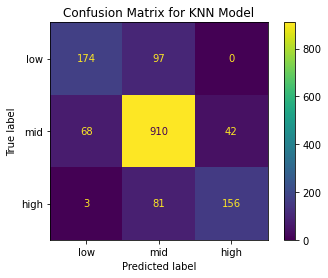

Accuracy: 0.8099281515349445
f1: 0.7500416602942033


In [31]:
knn_pred = knn_model.predict(x_test)
knn_accuracy = knn_model.score(x_test, y_test)

#create a confusion matrix to evaluate the model
cm_knn = confusion_matrix(y_test, knn_pred, labels=["low", "mid", "high"])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["low", "mid", "high"])

cm_disp.plot()

plt.title("Confusion Matrix for KNN Model")
plt.savefig("cm_knn.jpg")
plt.show()

f1 = f1_score(y_test, knn_pred, average="macro")
print('Accuracy:', knn_accuracy)
print('f1:', f1)